In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# Make predictions using ready made model (without any training)
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

In [4]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
# cache_dir indicates where to download data. I specified . which means current directory
# untar true will unzip it

228827136/228813984 [==============================] - 9s 0us/step


In [5]:
data_dir

'./datasets/flower_photos'

In [6]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir


PosixPath('datasets/flower_photos')

In [7]:
list(data_dir.glob('*/*.jpg'))[:5]

[PosixPath('datasets/flower_photos/tulips/130685040_3c2fcec63e_n.jpg'),
 PosixPath('datasets/flower_photos/tulips/16765283686_0315ae00a8.jpg'),
 PosixPath('datasets/flower_photos/tulips/14087361621_9fefb8dbef.jpg'),
 PosixPath('datasets/flower_photos/tulips/3516269489_cef36e87a6.jpg'),
 PosixPath('datasets/flower_photos/tulips/5813495998_64be1b8ab6_n.jpg')]

In [8]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [9]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[PosixPath('datasets/flower_photos/roses/2675221506_5286c0595f.jpg'),
 PosixPath('datasets/flower_photos/roses/3550491463_3eb092054c_m.jpg'),
 PosixPath('datasets/flower_photos/roses/12240165555_98625b1e88_n.jpg'),
 PosixPath('datasets/flower_photos/roses/15802657001_40fe77c030_m.jpg'),
 PosixPath('datasets/flower_photos/roses/12395698413_c0388278f7.jpg')]

In [11]:
import PIL

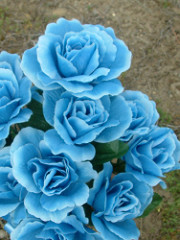

In [12]:
PIL.Image.open(str(roses[1]))

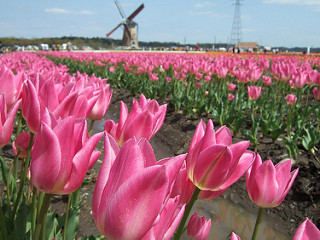

In [13]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

In [14]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [15]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [16]:
flowers_images_dict['roses'][:5]

[PosixPath('datasets/flower_photos/roses/2675221506_5286c0595f.jpg'),
 PosixPath('datasets/flower_photos/roses/3550491463_3eb092054c_m.jpg'),
 PosixPath('datasets/flower_photos/roses/12240165555_98625b1e88_n.jpg'),
 PosixPath('datasets/flower_photos/roses/15802657001_40fe77c030_m.jpg'),
 PosixPath('datasets/flower_photos/roses/12395698413_c0388278f7.jpg')]

In [17]:
str(flowers_images_dict['roses'][0])

'datasets/flower_photos/roses/2675221506_5286c0595f.jpg'

In [18]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))

In [19]:
img.shape

(375, 500, 3)

In [20]:
cv2.resize(img,(224,224)).shape

(224, 224, 3)

In [21]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [22]:
X = np.array(X)
y = np.array(y)

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [24]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [25]:
X[0].shape

(224, 224, 3)

In [26]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

In [27]:
x0_resized = cv2.resize(X[0], IMAGE_SHAPE)
x1_resized = cv2.resize(X[1], IMAGE_SHAPE)
x2_resized = cv2.resize(X[2], IMAGE_SHAPE)

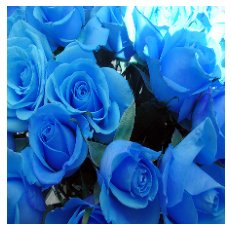

In [28]:
plt.axis('off')
plt.imshow(X[0])

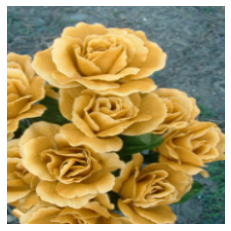

In [29]:
plt.axis('off')
plt.imshow(X[1])

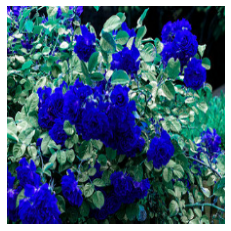

In [30]:
plt.axis('off')
plt.imshow(X[2])

In [31]:
predicted = classifier.predict(np.array([x0_resized, x1_resized, x2_resized]))
predicted = np.argmax(predicted, axis=1)
predicted

array([722, 795, 550])

Now take pre-trained model and retrain it using flowers images

In [34]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [35]:
num_of_flowers = 5

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [36]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
86/86 [==============================] - 12s 83ms/step - loss: 0.8346 - acc: 0.6860
Epoch 2/5
86/86 [==============================] - 7s 83ms/step - loss: 0.4172 - acc: 0.8576
Epoch 3/5
86/86 [==============================] - 7s 84ms/step - loss: 0.3277 - acc: 0.8917
Epoch 4/5
86/86 [==============================] - 7s 83ms/step - loss: 0.2769 - acc: 0.9132
Epoch 5/5
86/86 [==============================] - 7s 83ms/step - loss: 0.2380 - acc: 0.9295


In [37]:
model.evaluate(X_test_scaled,y_test)

29/29 [==============================] - 3s 95ms/step - loss: 0.3494 - acc: 0.8845


[0.3494235575199127, 0.8845316171646118]